# Análisis estadístico de correlación en la presencia de las empresas y estres hídrico

In [44]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
from shapely.geometry import Polygon

## Carga del dataset de estrés hídrico

In [45]:
# Cargar el CSV con los cuerpos de agua y convertir geometría en polígonos
df = pd.read_csv('Estres_Hid_DataFrame.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)

# Definir el área total de estudio (bounds)
xmin, ymin, xmax, ymax = gdf.total_bounds

# Crear el grid (rejilla)
grid_size = 0.1  # tamaño de las celdas (ajústalo según el nivel de detalle que necesites)
grid_cells = []
x = xmin
while x < xmax:
    y = ymin
    while y < ymax:
        grid_cells.append(Polygon([(x, y), (x+grid_size, y), (x+grid_size, y+grid_size), (x, y+grid_size)]))
        y += grid_size
    x += grid_size

grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)

# Intersección entre el grid y los cuerpos de agua
intersection = gpd.overlay(grid, gdf, how='intersection')

# Calcular proporción de área de cada cuerpo de agua en cada celda utilizando el área en KM2 de tu CSV
intersection['area_fraction'] = intersection['AREA_KM2'] / intersection.groupby('CLV_ACUI')['AREA_KM2'].transform('sum')

# Repartir el estrés hídrico proporcionalmente
intersection['stress_per_cell'] = intersection['ESTRES_HID'] * intersection['area_fraction']


## Carga del dataset de la presencia de las empresas

In [46]:
# --- Cargar datos de las empresas ---

# Cargar el CSV de las empresas
empresas_df = pd.read_csv('data_agricola24.csv')

# Convertir coordenadas de las empresas a puntos geoespaciales
empresas_gdf = gpd.GeoDataFrame(empresas_df, geometry=gpd.points_from_xy(empresas_df.x, empresas_df.y))
empresas_gdf.set_crs(epsg=4326, inplace=True)

# --- Asignar un peso a las empresas según PER_OCU ---

# Ejemplo de diccionario de pesos basado en PER_OCU (personalízalo con los valores correctos)
pesos_per_ocu = {
    '0 a 5 personas': 2.5,
    '6 a 10 personas': 8,
    '11 a 30 personas': 20.5,
    '31 a 50 personas': 40.5,
    '51 a 100 personas': 75.5,
    '101 a 250 personas': 175.5,
    '251 y mÃ¡s personas': 375.5
}

# Asignar el peso basado en PER_OCU a cada empresa
empresas_gdf['weight'] = empresas_gdf['PER_OCU'].map(pesos_per_ocu)

# --- Asociar empresas al grid ---

# Asociar las empresas a las celdas del grid
empresas_in_grid = gpd.sjoin(empresas_gdf, grid, how='left', predicate='within')


# Sumar los pesos de las empresas dentro de cada celda
empresas_density = empresas_in_grid.groupby('index_right').agg(
    total_weight=('weight', 'sum')
).reset_index()

In [47]:
# --- Combinar estrés hídrico y densidad de empresas ---

# Hacer un merge con la intersección del grid y cuerpos de agua
combined_data = pd.merge(intersection, empresas_density, left_index=True, right_on='index_right', how='left')

# Rellenar los NaN en celdas sin empresas con 0
combined_data['total_weight'].fillna(0, inplace=True)

# Ahora puedes sumarizar por cada celda del grid el estrés hídrico y la densidad de empresas
final_summary = combined_data.groupby('geometry').agg(
    total_stress=('stress_per_cell', 'sum'),
    weighted_density=('total_weight', 'sum')
).reset_index()

# Verificar el resultado
print(final_summary.head())

                                            geometry  total_stress  \
0  MULTIPOLYGON (((-101.8973 20.21296, -101.8973 ...      0.041066   
1  POLYGON ((-101.92955 20.21296, -101.92954 20.2...      0.041066   
2  POLYGON ((-101.9973 20.41296, -101.9973 20.354...      0.041066   
3  MULTIPOLYGON (((-101.95617 20.31296, -101.9558...      0.041066   
4  POLYGON ((-101.8973 20.41296, -101.7973 20.412...      0.041066   

   weighted_density  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


C:\Users\itzan\AppData\Local\Temp\ipykernel_20284\3091646235.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['total_weight'].fillna(0, inplace=True)


In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
final_summary[['total_stress', 'weighted_density']] = scaler.fit_transform(final_summary[['total_stress', 'weighted_density']])


print(final_summary.head())

# Guardar el resultado en un archivo CSV
final_summary.to_csv('final_summary.csv', index=False)

# Guardar el grid en un archivo shapefile
# grid.to_file('grid.shp')

                                            geometry  total_stress  \
0  MULTIPOLYGON (((-101.8973 20.21296, -101.8973 ...     -0.119256   
1  POLYGON ((-101.92955 20.21296, -101.92954 20.2...     -0.119256   
2  POLYGON ((-101.9973 20.41296, -101.9973 20.354...     -0.119256   
3  MULTIPOLYGON (((-101.95617 20.31296, -101.9558...     -0.119256   
4  POLYGON ((-101.8973 20.41296, -101.7973 20.412...     -0.119256   

   weighted_density  
0         -0.167428  
1         -0.167428  
2         -0.167428  
3         -0.167428  
4         -0.167428  


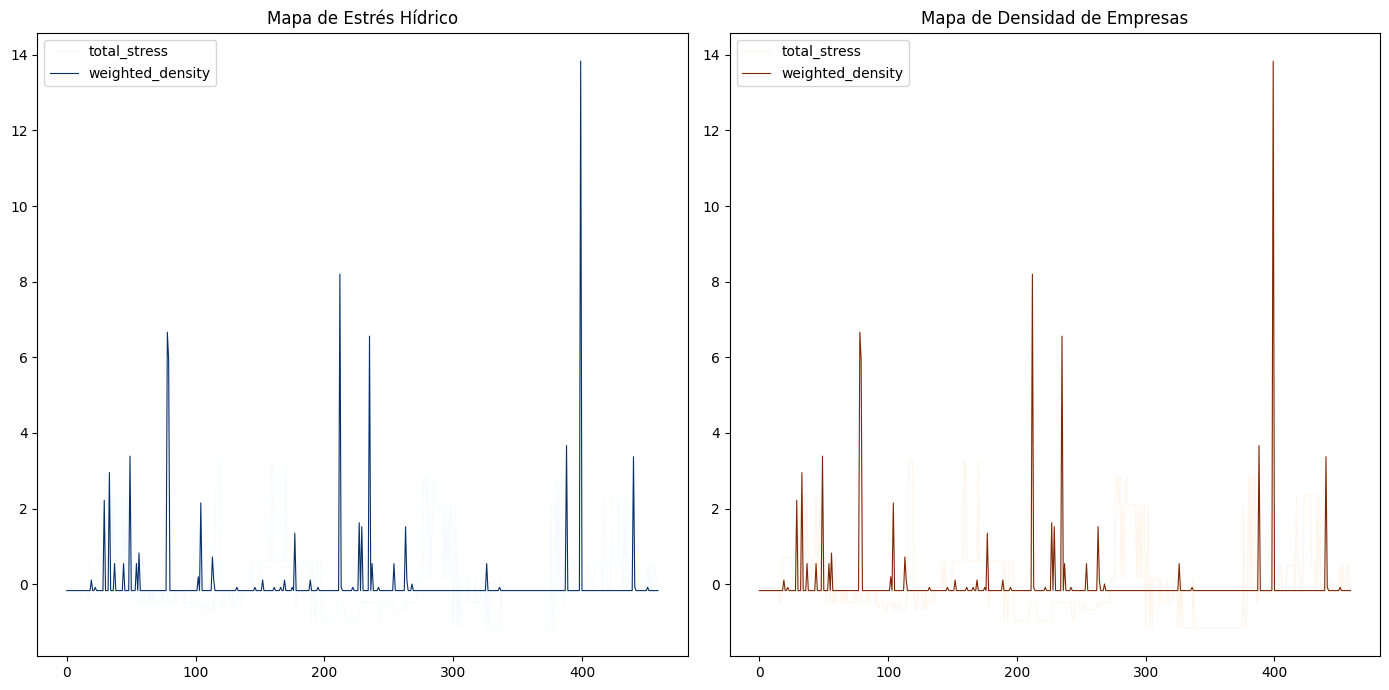

In [49]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Mapa de estrés hídrico utilizando GeoPandas
final_summary.plot(column='total_stress', cmap='Blues', linewidth=0.8, ax=ax[0])
ax[0].set_title('Mapa de Estrés Hídrico')

# Mapa de densidad de empresas
final_summary.plot(column='weighted_density', cmap='Oranges', linewidth=0.8, ax=ax[1])
ax[1].set_title('Mapa de Densidad de Empresas')

plt.tight_layout()
plt.show()


In [50]:
from esda.moran import Moran
from libpysal.weights import Queen

# Crear un objeto de pesos espaciales utilizando la vecindad de las celdas (Queen contiguity)
w = Queen.from_dataframe(final_summary)

# Calcular Moran's I para el estrés hídrico
mi_stress = Moran(final_summary['total_stress'], w)

print(f"Moran's I para el estrés hídrico: {mi_stress.I}")
print(f"p-value: {mi_stress.p_sim}")

# Calcular Moran's I para la densidad de empresas
mi_density = Moran(final_summary['weighted_density'], w)

print(f"Moran's I para la densidad de empresas: {mi_density.I}")
print(f"p-value: {mi_density.p_sim}")


Moran's I para el estrés hídrico: 0.6741804450545872
p-value: 0.001
Moran's I para la densidad de empresas: 0.015418399571301653
p-value: 0.147


C:\Users\itzan\AppData\Local\Temp\ipykernel_20284\2589931175.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(final_summary)


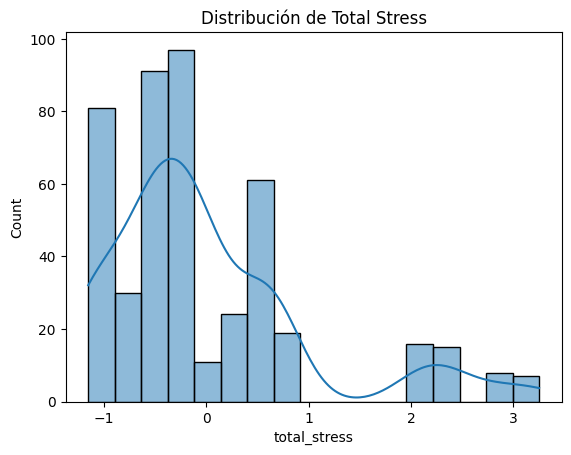

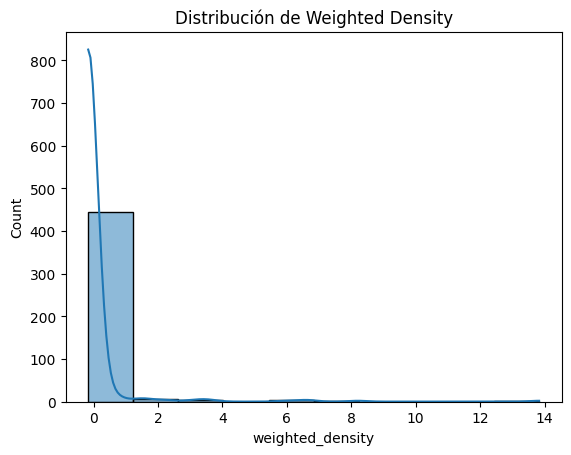

Shapiro-Wilk test for total_stress: Statistic=0.8414812221629969, p-value=4.685763350828852e-21
Shapiro-Wilk test for weighted_density: Statistic=0.16049129699647624, p-value=7.253170577135711e-41
Kolmogorov-Smirnov test for total_stress: Statistic=0.19746370967878452, p-value=3.4176926573245766e-16
Kolmogorov-Smirnov test for weighted_density: Statistic=0.4708310837810438, p-value=4.5066701738116256e-94


In [51]:
from scipy.stats import shapiro, kstest, normaltest
import seaborn as sns
import matplotlib.pyplot as plt

# Verificación visual con histogramas
sns.histplot(final_summary['total_stress'], kde=True)
plt.title('Distribución de Total Stress')
plt.show()

sns.histplot(final_summary['weighted_density'], kde=True)
plt.title('Distribución de Weighted Density')
plt.show()

# Prueba de normalidad - Shapiro-Wilk
stat_stress, p_stress = shapiro(final_summary['total_stress'])
stat_density, p_density = shapiro(final_summary['weighted_density'])

print(f'Shapiro-Wilk test for total_stress: Statistic={stat_stress}, p-value={p_stress}')
print(f'Shapiro-Wilk test for weighted_density: Statistic={stat_density}, p-value={p_density}')

# Prueba de normalidad - Kolmogorov-Smirnov
stat_stress_ks, p_stress_ks = kstest(final_summary['total_stress'], 'norm')
stat_density_ks, p_density_ks = kstest(final_summary['weighted_density'], 'norm')

print(f'Kolmogorov-Smirnov test for total_stress: Statistic={stat_stress_ks}, p-value={p_stress_ks}')
print(f'Kolmogorov-Smirnov test for weighted_density: Statistic={stat_density_ks}, p-value={p_density_ks}')

In [52]:
# Calcular la correlación de Pearson entre el estrés hídrico y la densidad de empresas
correlation_pearson = final_summary[['total_stress', 'weighted_density']].corr(method='pearson')

# Mostrar el resultado
print(correlation_pearson)

                  total_stress  weighted_density
total_stress          1.000000         -0.040619
weighted_density     -0.040619          1.000000


In [53]:
from scipy.stats import pearsonr, spearmanr

# Pearson correlation
corr_pearson, _ = pearsonr(final_summary['total_stress'], final_summary['weighted_density'])
print(f'Pearson correlation: {corr_pearson}')

# Spearman correlation
corr_spearman, _ = spearmanr(final_summary['total_stress'], final_summary['weighted_density'])
print(f'Spearman correlation: {corr_spearman}')


Pearson correlation: -0.040618527361383584
Spearman correlation: 0.019706080216114016
